In [2]:
using LinearAlgebra
using Plots
using Printf
using SparseArrays
using Arpack

# Infinite DMRG

In [16]:
bc = 0 #boundary condition
t = 1
U = 0.2
# Number of states kept
n_kept_states = 10

# Number of iterations.  Final lattice size is 2*n_iter + 2
n_iter = 34
system_size = 2*n_iter+2 #Number of unitcells

###########################################################
# Operators in 2 dimensional hilbert space for single site
###########################################################

C = sparse([0 0;1 0])#annihilation operator -> sigma_minus
C_dag = sparse(C')#creation operator -> sigma_plus

# Number Operator:
n = C_dag*C


#Identity matrix
I_d = sparse(I, 4, 4)
Id = sparse(I, 2, 2)

############################################################################
#              Initial blocks
#               We assume reflection symmetry so we only need 1 block
#               The operator acts on the inner-most site of the block
#               +---------+    +---------+
#               |       #*|    |*#       |
#               +---------+    +---------+
#               odd sites are spin up and evens represent spin downs
############################################################################

#Each site is considered to be a unitcell that the left side is spin-down and the right side is spin-up

C_up = kron(Id ,C)    #second site in unitcell
C_down = kron(C,Id)   #first site in unitcell

C_up_dag = sparse(C_up')
C_down_dag = sparse(C_down')
n_up = kron(Id,n)
n_down = kron(n,Id)

# Operators for last site added to block 
block_Cu_last = C_up
block_Cud_last = C_up_dag
block_Cd_last = C_down
block_Cdd_last = C_down_dag
block_nu_last = n_up
block_nd_last = n_down
block_Id  = kron(Id,Id)

# one site Hamiltonian
block_H = U*(n_up*n_down)

# initializing a few useful quantities:
EE = zeros(n_iter)
system_size = zeros(n_iter)
truncation_error = zeros(n_iter)
energy_per_bond = zeros(n_iter)

# Saving operators for finite dmrg

block_Cu_list = Dict()
block_Cu_list[1] = block_Cu_last

block_Cud_list = Dict()
block_Cud_list[1] = block_Cud_last

block_Cd_list = Dict()
block_Cd_list[1] = block_Cd_last

block_Cdd_list = Dict()
block_Cdd_list[1] = block_Cdd_last

block_H_list = Dict()
block_H_list[1] = block_H

block_Id_list = Dict()
block_Id_list[1] = block_Id;

In [17]:
time  = @elapsed begin
    
for l=1:n_iter      
        ##################################################################
        #       Get the 2*chi-dimensional operators for the block +
        #       site where chi = n_kept_states
        ##################################################################
    
        block_nu_last = kron(block_Id,n_up)
        block_nd_last = kron(block_Id,n_down)
        
        block_hopping = -t*(kron(block_Cud_last,C_up) + kron(block_Cdd_last,C_down))
        block_hopping += -t*(kron(block_Cu_last,C_up_dag) + kron(block_Cd_last,C_down_dag))
        
        interacting = U*(block_nu_last*block_nd_last)
        
        block_H = kron(block_H,I_d) + block_hopping + interacting
    
        block_Cu_last = kron(block_Id,C_up)
        block_Cud_last = kron(block_Id,C_up_dag)
        
        block_Cd_last = kron(block_Id,C_down)
        block_Cdd_last = kron(block_Id,C_down_dag)
        
        block_Id = kron(block_Id,I_d)
        
        ############################################
        #     HAMILTONIAN MATRIX for superblock
        ############################################
        
        hopping = -t*(kron(block_Cud_last,block_Cu_last) + kron(block_Cdd_last,block_Cd_last))
        
        hopping += - t*(kron(block_Cu_last,block_Cud_last) + kron(block_Cd_last,block_Cdd_last))
        H_superblock = kron(block_H,block_Id) + kron(block_Id, block_H) + hopping
  
        H_superblock = (H_superblock + sparse(H_superblock'))/2  
        
        #########################################
        #    Diagonalizing the Hamiltonian
        ##########################################
        
        Energy,Psi = eigen(Matrix(H_superblock))
        sort_ind = sortperm(Energy,rev=false)
        Energy = sort(Energy,rev=false)
        Psi = Psi[:, sort_ind]
        energy =  Energy[1]
        Psi = Psi[:,1]
        energy_per_bond[l] = energy/(l * 2 + 2)
        system_size[l] = 2*(l+1)
        
        ##########################################
        #   Form the reduced density matrix
        ##########################################
        
        dim_block = size(block_H,1)
        Psi_matrix = reshape(Psi, (dim_block, dim_block))
        block_Rho = Psi_matrix*Psi_matrix'
        
        ##############################################
        #       Diagonalize the density matrix
        ###############################################
        
        n_kept_temp = min(dim_block, n_kept_states)
        D, V = eigen(Matrix(block_Rho))
        sort_ind = sortperm(D,rev=true)
        D = sort(D,rev=true)
        V = V[:, sort_ind]
        ES = D

        for i=1:length(ES)
            if ES[i] < 10^(-15)
                ES[i] = 10^(-15)
            end
        end
        
        EE[l] = -dot(ES,log.(ES))
        
        ######################################
        #  Construct the truncation operator
        ######################################
        block_T = V[:,1:n_kept_temp]
        block_T = sparse(block_T)
        
        truncation_error[l] = 1 - sum(D[1:n_kept_temp])
        
        @printf("iter: %s\t total_En: %s\t En_per_bound: %s\t trunErr:  %s\n",l,energy,energy_per_bond[l],truncation_error[l])
        
        #############################################################
        #   Transform the block operators into the truncated basis
        #############################################################
        
        block_H  = block_T'*block_H*block_T
        
        block_Cu_last  = block_T'*block_Cu_last*block_T
        block_Cud_last = block_T'*block_Cud_last*block_T
        
        block_Cd_last = block_T'*block_Cd_last*block_T
        block_Cdd_last = block_T'*block_Cdd_last*block_T
        
        block_Id = block_T'*block_Id*block_T
        
        ###################################
        # Saving operators for finite dmrg
        ###################################
        block_Cu_list[l+1] = block_Cu_last
        block_Cud_list[l+1] = block_Cud_last
        
        block_Cd_list[l+1] = block_Cd_last
        block_Cdd_list[l+1] = block_Cdd_last
        
        block_H_list[l+1] = block_H
        block_Id_list[l+1] = block_Id
        
    end
end

iter: 1	 total_En: -4.2762938562356245	 En_per_bound: -1.0690734640589061	 trunErr:  0.0026918529224396748
iter: 2	 total_En: -6.6623331364323	 En_per_bound: -1.11038885607205	 trunErr:  0.003114690229743533
iter: 3	 total_En: -9.057960998499242	 En_per_bound: -1.1322451248124052	 trunErr:  0.003980687296886942
iter: 4	 total_En: -11.451322955415058	 En_per_bound: -1.1451322955415058	 trunErr:  0.004857339890443901
iter: 5	 total_En: -13.848631273994705	 En_per_bound: -1.1540526061662255	 trunErr:  0.0037495575156151206
iter: 6	 total_En: -16.246972171241786	 En_per_bound: -1.1604980122315562	 trunErr:  0.004768183175943075
iter: 7	 total_En: -18.64735411500937	 En_per_bound: -1.1654596321880857	 trunErr:  0.003320787365305611
iter: 8	 total_En: -21.049702351742617	 En_per_bound: -1.1694279084301453	 trunErr:  0.004575169074947372
iter: 9	 total_En: -23.452265707392232	 En_per_bound: -1.1726132853696116	 trunErr:  0.0031353400024360933
iter: 10	 total_En: -25.856939052303908	 En_per_bo

48.4621247

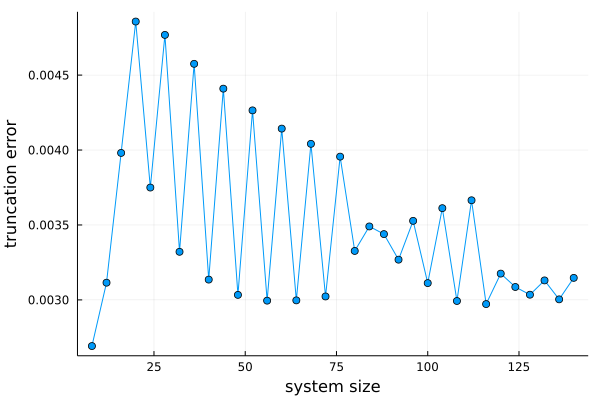

In [22]:
plot(2*system_size,truncation_error,markershape = :circle,legend = false,xlabel = "system size",ylabel = "truncation error")

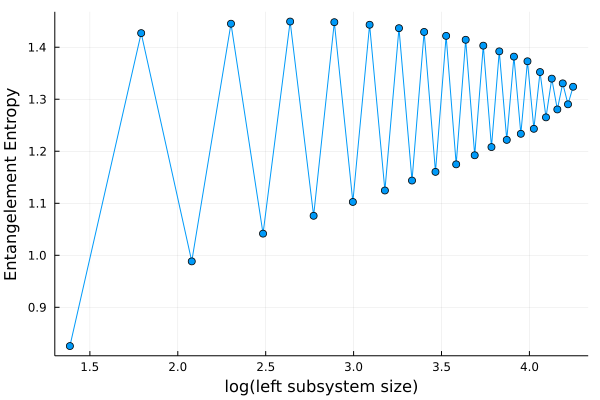

In [23]:
plot(log.(system_size),EE,markershape = :circle,legend = false,xlabel = "log(left subsystem size)",ylabel ="Entangelement Entropy")

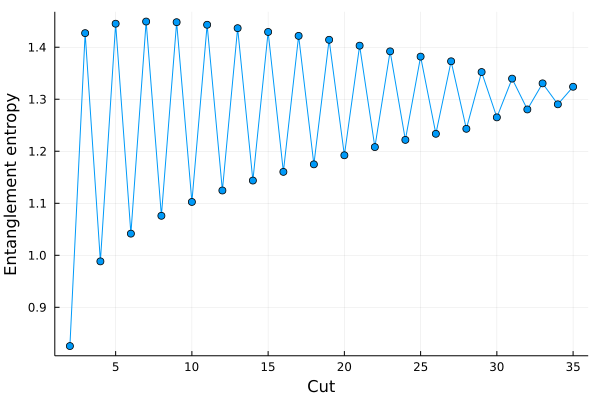

In [24]:
X = range(2,stop=length(EE)+1,length=length(EE))
plot(X,EE,markershape = :circle,legend = false,xlabel = "Cut",ylabel ="Entanglement entropy")

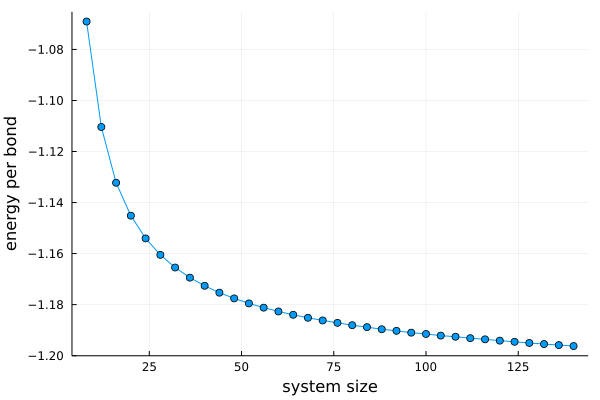

In [25]:
plot(2*system_size,energy_per_bond,markershape = :circle,legend = false,xlabel = "system size",ylabel ="energy per bond")

# Finite DMRG

In [26]:
#Loading operators:
block_Cu_left = block_Cu_list[n_iter+1]
block_Cud_left = block_Cud_list[n_iter+1]

block_Cd_left = block_Cd_list[n_iter+1]
block_Cdd_left = block_Cdd_list[n_iter+1]

block_H_left = block_H_list[n_iter+1]
block_Id_left = block_Id_list[n_iter+1];

## DMRG Sweeps

### Left-to-Right Sweep

In [27]:
system_size = 2*n_iter + 2

###############################
#   Begin main iterations
###############################

n_iter_l = n_iter-1 #because there are already two sites in the system

truncation_error = zeros(n_iter_l)
energy_per_bond = zeros(n_iter_l)

time  = @elapsed begin
    
for l=1:n_iter_l
        ###########################
        #  Right block operators
        ###########################

        #Shrink the right block using the operators from infinite dmrg:
        block_H_right = block_H_list[n_iter - l]

        block_Cu_right = block_Cu_list[n_iter - l]
        block_Cud_right = block_Cud_list[n_iter - l]

        block_Cd_right = block_Cd_list[n_iter - l]
        block_Cdd_right = block_Cdd_list[n_iter - l]

        block_Id_right = block_Id_list[n_iter - l]
        
        #constructing the right block hamiltonian
        block_nu_right = kron(block_Id_right,n_up)
        block_nd_right = kron(block_Id_right,n_down)
        
        block_hopping = -t*(kron(block_Cud_right,C_up) + kron(block_Cdd_right,C_down))
        block_hopping += -t*(kron(block_Cu_right,C_up_dag) + kron(block_Cd_right,C_down_dag))
        
        interacting = U*(block_nu_right*block_nd_right)
        
        block_H_right = kron(block_H_right, I_d) + block_hopping + interacting
        
        block_Cu_right = kron(block_Id_right,C_up)
        block_Cud_right = kron(block_Id_right,C_up_dag)

        block_Cd_right = kron(block_Id_right,C_down)
        block_Cdd_right = kron(block_Id_right,C_down_dag)

        block_Id_right = kron(block_Id_right,I_d)
        
        ##############################
        #  Adding site to left block
        ##############################
        
        #constructing the right block hamiltonian
        block_nu_left = kron(block_Id_left,n_up)
        block_nd_left = kron(block_Id_left,n_down)
        
        block_hopping = -t*(kron(block_Cud_left,C_up) + kron(block_Cdd_left,C_down))
        block_hopping += -t*(kron(block_Cu_left,C_up_dag) + kron(block_Cd_left,C_down_dag))
        
        interacting = U*(block_nu_left*block_nd_left)
        
        block_H_left = kron(block_H_left, I_d) + block_hopping + interacting
        
        block_Cu_left = kron(block_Id_left,C_up)
        block_Cud_left = kron(block_Id_left,C_up_dag)
    
        block_Cd_left = kron(block_Id_left,C_down)
        block_Cdd_left = kron(block_Id_left,C_down_dag)
    
        block_Id_left = kron(block_Id_left,I_d)
        
        ############################################
        #     HAMILTONIAN MATRIX for superblock
        ############################################
        
        hopping = -t*(kron(block_Cud_left,block_Cu_right) + kron(block_Cu_left,block_Cud_right))
        
        hopping += - t*(kron(block_Cdd_left,block_Cd_right) + kron(block_Cd_left,block_Cdd_right))
        H_superblock = kron(block_H_left, block_Id_right) + kron(block_Id_left,block_H_right) + hopping
  
        H_superblock = (H_superblock + sparse(H_superblock'))/2 
        
        #########################################
        #    Diagonalizing the Hamiltonian
        ##########################################
        
        Energy,Psi = eigen(Matrix(H_superblock))
        sort_ind = sortperm(Energy,rev=false)
        Energy = sort(Energy,rev=false)
        Psi = Psi[:, sort_ind]
        energy =  Energy[1]
        Psi = Psi[:,1]
        energy_per_bond[l] = energy/system_size
        
        ##########################################
        #   Form the reduced density matrix
        ##########################################
        
        dim_block_left = size(block_H_left,1)
        dim_block_right = size(block_H_right,1)
        Psi_matrix = reshape(Psi, (dim_block_right, dim_block_left))
        block_Rho = Psi_matrix'*Psi_matrix
        
        #######################################
        #   Diagonalize the density matrix 
        #######################################
        
        D, V = eigen(Matrix(block_Rho))
        sort_ind = sortperm(D,rev=true)
        D = sort(D,rev=true)
        V = V[:, sort_ind]
        n_kept_temp = min(length(D), n_kept_states)
        
        ######################################
        #  Construct the truncation operator
        ######################################
        block_T = V[:,1:n_kept_temp]
        block_T = sparse(block_T)
        
        truncation_error[l] = 1 - sum(D[1:n_kept_temp])
        
        @printf("iter: %s\t total_En: %s\t En_per_bound: %s\t trunErr:  %s\n",l,energy,energy_per_bond[l],truncation_error[l])
        
        #############################################################
        #   Transform the block operators into the truncated basis
        #############################################################
        block_H_left  = block_T'*block_H_left*block_T
        
        block_Cu_left  = block_T'*block_Cu_left*block_T
        block_Cud_left = block_T'*block_Cud_left*block_T
        
        block_Cd_left = block_T'*block_Cd_left*block_T
        block_Cdd_left = block_T'*block_Cdd_left*block_T
        
        block_Id_left = block_T'*block_Id_left*block_T
        
        ###################################
        # Saving operators for finite dmrg
        ###################################
        
        block_Cu_list[n_iter+l+1] = block_Cu_left
        block_Cud_list[n_iter+l+1] = block_Cud_left
        
        block_Cd_list[n_iter+l+1] = block_Cd_left
        block_Cdd_list[n_iter+l+1] = block_Cdd_left
        
        block_H_list[n_iter+l+1] = block_H_left
        block_Id_list[n_iter+l+1] = block_Id_left

    end
end

iter: 1	 total_En: -83.73621472521589	 En_per_bound: -1.1962316389316556	 trunErr:  0.003006850254718252
iter: 2	 total_En: -83.73619335900555	 En_per_bound: -1.1962313337000794	 trunErr:  0.0031410706237405828
iter: 3	 total_En: -83.7363250331764	 En_per_bound: -1.1962332147596628	 trunErr:  0.0030110034598181956
iter: 4	 total_En: -83.7362042990021	 En_per_bound: -1.1962314899857442	 trunErr:  0.0031132517147621774
iter: 5	 total_En: -83.73677670696054	 En_per_bound: -1.1962396672422935	 trunErr:  0.0030390129104624908
iter: 6	 total_En: -83.73637176751792	 En_per_bound: -1.1962338823931131	 trunErr:  0.0030345287492352657
iter: 7	 total_En: -83.73809101338844	 En_per_bound: -1.1962584430484062	 trunErr:  0.0031654325458767563
iter: 8	 total_En: -83.7370176089963	 En_per_bound: -1.196243108699947	 trunErr:  0.002824056628300431
iter: 9	 total_En: -83.74368050323909	 En_per_bound: -1.1963382929034156	 trunErr:  0.003205114634988848
iter: 10	 total_En: -83.74260012813764	 En_per_bound:

45.6427257

### Right-to-Left Sweep

In [28]:
#Loading operators:
block_Cu_right = block_Cu_list[1]
block_Cud_right = block_Cud_list[1]

block_Cd_right = block_Cd_list[1]
block_Cdd_right = block_Cdd_list[1]

block_H_right = block_H_list[1]
block_Id_right = block_Id_list[1];

In [29]:
n_iter_r = 2*n_iter_l+1 #from last sweep

truncation_error = zeros(n_iter_r)
energy_per_bond = zeros(n_iter_r)

###############################
#   Begin main iterations
###############################
time  = @elapsed begin
for l=1:n_iter_r
        
        #########################
        #  Left block operators
        #########################
        # using the left block operators from the privious left to right sweep:

        block_H_left = block_H_list[n_iter_r - (l-1)]

        block_Cu_left = block_Cu_list[n_iter_r - (l-1)]
        block_Cud_left = block_Cud_list[n_iter_r - (l-1)]

        block_Cd_left = block_Cd_list[n_iter_r - (l-1)]
        block_Cdd_left = block_Cdd_list[n_iter_r - (l-1)]

        block_Id_left = block_Id_list[n_iter_r - (l-1)]
        
        #Left block hamiltonian:
        block_nu_left = kron(block_Id_left,n_up)
        block_nd_left = kron(block_Id_left,n_down)
        
        block_hopping = -t*(kron(block_Cud_left,C_up) + kron(block_Cdd_left,C_down))
        block_hopping += -t*(kron(block_Cu_left,C_up_dag) + kron(block_Cd_left,C_down_dag))
        
        interacting = U*(block_nu_left*block_nd_left)
        
        block_H_left = kron(block_H_left, I_d) + block_hopping + interacting
        
        block_Cu_left = kron(block_Id_left,C_up)
        block_Cud_left = kron(block_Id_left,C_up_dag)

        block_Cd_left = kron(block_Id_left,C_down)
        block_Cdd_left = kron(block_Id_left,C_down_dag)

        block_Id_left = kron(block_Id_left,I_d)
        
        #########################################################
        #  Adding site to right block & right block hamiltonian
        #########################################################
        
        #Right block hamiltonian:
        block_nu_right = kron(block_Id_right,n_up)
        block_nd_right = kron(block_Id_right,n_down)
        
        block_hopping = -t*(kron(block_Cud_right,C_up) + kron(block_Cdd_right,C_down))
        block_hopping += -t*(kron(block_Cu_right,C_up_dag) + kron(block_Cd_right,C_down_dag))
        
        interacting = U*(block_nu_right*block_nd_right)
        
        block_H_right = kron(block_H_right, I_d) + block_hopping + interacting
        
        block_Cu_right = kron(block_Id_right,C_up)
        block_Cud_right = kron(block_Id_right,C_up_dag)

        block_Cd_right = kron(block_Id_right,C_down)
        block_Cdd_right = kron(block_Id_right,C_down_dag)

        block_Id_right = kron(block_Id_right,I_d)
        
        ############################################
        #     HAMILTONIAN MATRIX for superblock
        ############################################
        
        hopping = -t*(kron(block_Cud_left,block_Cu_right) + kron(block_Cu_left,block_Cud_right))
        hopping += - t*(kron(block_Cdd_left,block_Cd_right) + kron(block_Cd_left,block_Cdd_right))
        
        H_superblock = kron(block_H_left, block_Id_right) + kron(block_Id_left,block_H_right) + hopping
  
        H_superblock = (H_superblock + sparse(H_superblock'))/2 
        
        #########################################
        #    Diagonalizing the Hamiltonian
        ##########################################
        
        Energy,Psi = eigen(Matrix(H_superblock))
        sort_ind = sortperm(Energy,rev=false)
        Energy = sort(Energy,rev=false)
        Psi = Psi[:, sort_ind]
        energy =  Energy[1]
        Psi = Psi[:,1]
        energy_per_bond[l] = energy/system_size
        
        ##########################################
        #   Form the reduced density matrix
        ##########################################
        
        dim_block_left = size(block_H_left,1)
        dim_block_right = size(block_H_right,1)
        Psi_matrix = reshape(Psi, (dim_block_right, dim_block_left))
        block_Rho = Psi_matrix*Psi_matrix'
        
        #######################################
        #   Diagonalize the density matrix 
        #######################################
        
        D, V = eigen(Matrix(block_Rho))
        sort_ind = sortperm(D,rev=true)
        D = sort(D,rev=true)
        V = V[:, sort_ind]
        n_kept_temp = min(length(D), n_kept_states)
        
        ######################################
        #  Construct the truncation operator
        ######################################
        block_T = V[:,1:n_kept_temp]
        block_T = sparse(block_T)
        
        truncation_error[l] = 1 - sum(D[1:n_kept_temp])
        
        @printf("iter: %s\t total_En: %s\t En_per_bound: %s\t trunErr:  %s\n",l,energy,energy_per_bond[l],truncation_error[l])
        
        #############################################################
        #   Transform the block operators into the truncated basis
        #############################################################

        block_H_right = block_T'*block_H_right*block_T
        
        block_Cu_right = block_T'*block_Cu_right*block_T
        block_Cud_right = block_T'*block_Cud_right*block_T
        
        block_Cd_right = block_T'*block_Cd_right*block_T
        block_Cdd_right = block_T'*block_Cdd_right*block_T
        
        block_Id_right = block_T'*block_Id_right*block_T
        
        ###################################
        # Saving operators for finite dmrg
        ###################################
        
        block_Cu_list[l+1] = block_Cu_right
        block_Cud_list[l+1] = block_Cud_right
        
        block_Cd_list[l+1] = block_Cd_right
        block_Cdd_list[l+1] = block_Cdd_right
        
        block_H_list[l+1] = block_H_right
        block_Id_list[l+1] = block_Id_right
        
    end
end

iter: 1	 total_En: -83.80900738391989	 En_per_bound: -1.1972715340559985	 trunErr:  0.0024545826944654126
iter: 2	 total_En: -83.80907846386901	 En_per_bound: -1.197272549483843	 trunErr:  0.003455074860160945
iter: 3	 total_En: -83.81102283422938	 En_per_bound: -1.1973003262032769	 trunErr:  0.0029170729160429287
iter: 4	 total_En: -83.81128164197798	 En_per_bound: -1.1973040234568284	 trunErr:  0.003978709913381673
iter: 5	 total_En: -83.8122608546418	 En_per_bound: -1.1973180122091687	 trunErr:  0.0030041502818376475
iter: 6	 total_En: -83.81243667076136	 En_per_bound: -1.1973205238680193	 trunErr:  0.0037441831923883395
iter: 7	 total_En: -83.81564851512925	 En_per_bound: -1.1973664073589894	 trunErr:  0.003359110779448393
iter: 8	 total_En: -83.81302423576443	 En_per_bound: -1.1973289176537776	 trunErr:  0.003400788820763445
iter: 9	 total_En: -83.81750038337448	 En_per_bound: -1.1973928626196355	 trunErr:  0.0034979450110284027
iter: 10	 total_En: -83.81407285971487	 En_per_bound

87.7223663

### Re-iterate left to right sweep

In [30]:
#Loading operators:
block_Cu_left = block_Cu_list[1]
block_Cud_left = block_Cud_list[1]

block_Cd_left = block_Cd_list[1]
block_Cdd_left = block_Cdd_list[1]

block_H_left = block_H_list[1]
block_Id_left = block_Id_list[1];

In [31]:
truncation_error = zeros(n_iter_r)
energy_per_bond = zeros(n_iter_r)
EE = zeros(n_iter_r)

System_Size = zeros(n_iter_r)
time  = @elapsed begin
    
for l=1:n_iter_r

        ###########################
        #  Right block operators
        ###########################

        # using the right block from the privious right to left sweep:
        block_H_right = block_H_list[n_iter_r - (l-1)]

        block_Cu_right = block_Cu_list[n_iter_r - (l-1)]
        block_Cud_right = block_Cud_list[n_iter_r - (l-1)]

        block_Cd_right = block_Cd_list[n_iter_r - (l-1)]
        block_Cdd_right = block_Cdd_list[n_iter_r - (l-1)]

        block_Id_right = block_Id_list[n_iter_r - (l-1)]
 
        block_nu_right = kron(block_Id_right,n_up)
        block_nd_right = kron(block_Id_right,n_down)
        
        #Right block hamiltonian:
        
        block_hopping = -t*(kron(block_Cud_right,C_up) + kron(block_Cdd_right,C_down))
        block_hopping += -t*(kron(block_Cu_right,C_up_dag) + kron(block_Cd_right,C_down_dag))
        
        interacting = U*(block_nu_right*block_nd_right)
        
        block_H_right = kron(block_H_right, I_d) + block_hopping + interacting
        
        block_Cu_right = kron(block_Id_right,C_up)
        block_Cud_right = kron(block_Id_right,C_up_dag)

        block_Cd_right = kron(block_Id_right,C_down)
        block_Cdd_right = kron(block_Id_right,C_down_dag)

        block_Id_right = kron(block_Id_right,I_d)
        
        ##############################
        #  Adding site to left block
        ##############################
        
        block_nu_left = kron(block_Id_left,n_up)
        block_nd_left = kron(block_Id_left,n_down)
        
        block_hopping = -t*(kron(block_Cud_left,C_up) + kron(block_Cdd_left,C_down))
        block_hopping += -t*(kron(block_Cu_left,C_up_dag) + kron(block_Cd_left,C_down_dag))
        
        interacting = U*(block_nu_left*block_nd_left)
        
        block_H_left = kron(block_H_left, I_d) + block_hopping + interacting
        
        block_Cu_left = kron(block_Id_left,C_up)
        block_Cud_left = kron(block_Id_left,C_up_dag)

        block_Cd_left = kron(block_Id_left,C_down)
        block_Cdd_left = kron(block_Id_left,C_down_dag)

        block_Id_left = kron(block_Id_left,I_d)
        
        ############################################
        #     HAMILTONIAN MATRIX for superblock
        ############################################
        
        hopping = -t*(kron(block_Cud_left,block_Cu_right) + kron(block_Cu_left,block_Cud_right))
        hopping += - t*(kron(block_Cdd_left,block_Cd_right) + kron(block_Cd_left,block_Cdd_right))
        
        H_superblock = kron(block_H_left, block_Id_right) + kron(block_Id_left,block_H_right) + hopping
  
        H_superblock = (H_superblock + sparse(H_superblock'))/2 
        
                
        #########################################
        #    Diagonalizing the Hamiltonian
        ##########################################
        
        Energy,Psi = eigen(Matrix(H_superblock))
        sort_ind = sortperm(Energy,rev=false)
        Energy = sort(Energy,rev=false)
        Psi = Psi[:, sort_ind]
        energy =  Energy[1]
        Psi = Psi[:,1]
        energy_per_bond[l] = energy/system_size
        System_Size[l] = 2*(1+l)
        
        ##########################################
        #   Form the reduced density matrix
        ##########################################
        
        dim_block_left = size(block_H_left,1)
        dim_block_right = size(block_H_right,1)
        Psi_matrix = reshape(Psi, (dim_block_right, dim_block_left))
        block_Rho = Psi_matrix'*Psi_matrix
        
        ##############################################
        #       Diagonalize the density matrix
        ##############################################
        
        D, V = eigen(Matrix(block_Rho))
        sort_ind = sortperm(D,rev=true)
        D = sort(D,rev=true)
        V = V[:, sort_ind]
        ES = D
        n_kept_temp = min(length(D), n_kept_states)
        
        for i=1:length(ES)
            if ES[i] < 10^(-15)
                ES[i] = 10^(-15)
            end
        end
        
        EE[l] = -dot(ES,log.(ES))
        
        ######################################
        #  Construct the truncation operator
        ######################################
        block_T = V[:,1:n_kept_temp]
        block_T = sparse(block_T)
        
        truncation_error[l] = 1 - sum(D[1:n_kept_temp])
        
        @printf("iter: %s\t total_En: %s\t En_per_bound: %s\t trunErr:  %s\n",l,energy,energy_per_bond[l],truncation_error[l])
        
        #############################################################
        #   Transform the block operators into the truncated basis
        #############################################################

        block_H_left = block_T'*block_H_left*block_T
        block_Cu_left = block_T'*block_Cu_left*block_T
        block_Cud_left = block_T'*block_Cud_left*block_T
        block_Cd_left = block_T'*block_Cd_left*block_T
        block_Cdd_left = block_T'*block_Cdd_left*block_T
        block_Id_left = block_T'*block_Id_left*block_T
        
        ###################################
        # Saving operators for finite dmrg
        ###################################
        
        block_Cu_list[l+1] = block_Cu_left
        block_Cud_list[l+1] = block_Cud_left
        
        block_Cd_list[l+1] = block_Cd_left
        block_Cdd_list[l+1] = block_Cdd_left
        
        block_H_list[l+1] = block_H_left
        block_Id_list[l+1] = block_Id_left
    end
end

iter: 1	 total_En: -84.47998359482528	 En_per_bound: -1.206856908497504	 trunErr:  0.0012346636481794793
iter: 2	 total_En: -84.48088745824485	 En_per_bound: -1.2068698208320694	 trunErr:  0.0017879356149707037
iter: 3	 total_En: -84.47935529950617	 En_per_bound: -1.206847932850088	 trunErr:  0.00101202051753424
iter: 4	 total_En: -84.48170827796459	 En_per_bound: -1.2068815468280656	 trunErr:  0.001768950826987914
iter: 5	 total_En: -84.48036395816897	 En_per_bound: -1.2068623422595566	 trunErr:  0.000823927098853372
iter: 6	 total_En: -84.48262016703134	 En_per_bound: -1.2068945738147334	 trunErr:  0.001321898857333581
iter: 7	 total_En: -84.48206140647196	 En_per_bound: -1.2068865915210278	 trunErr:  0.0007526415916647711
iter: 8	 total_En: -84.48397274612627	 En_per_bound: -1.2069138963732324	 trunErr:  0.0010342364563143969
iter: 9	 total_En: -84.48391575281057	 En_per_bound: -1.2069130821830083	 trunErr:  0.0007218705231092359
iter: 10	 total_En: -84.48542264287023	 En_per_bound:

126.5533744

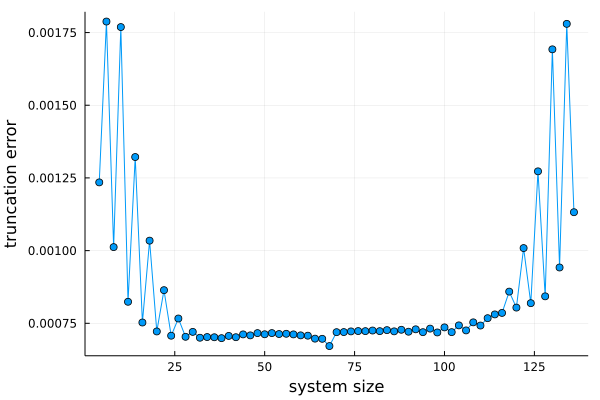

In [32]:
plot(System_Size,truncation_error,markershape = :circle,legend = false,xlabel = "system size",ylabel = "truncation error")

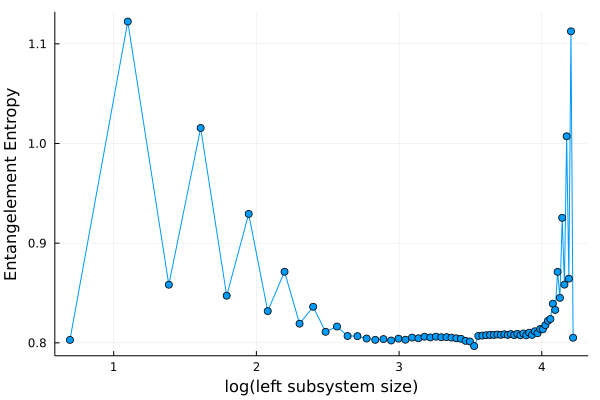

In [33]:
plot(log.(System_Size/2),EE,markershape = :circle,legend = false,xlabel = "log(left subsystem size)",ylabel ="Entangelement Entropy")

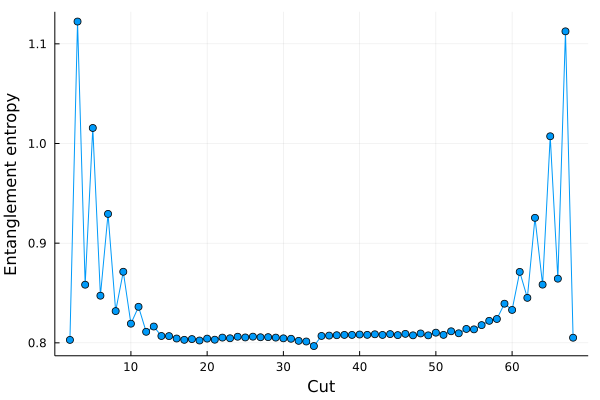

In [34]:
X = range(2,stop=length(EE)+1,length=length(EE))
plot(X,EE,markershape = :circle,legend = false,xlabel = "Cut",ylabel ="Entanglement entropy")

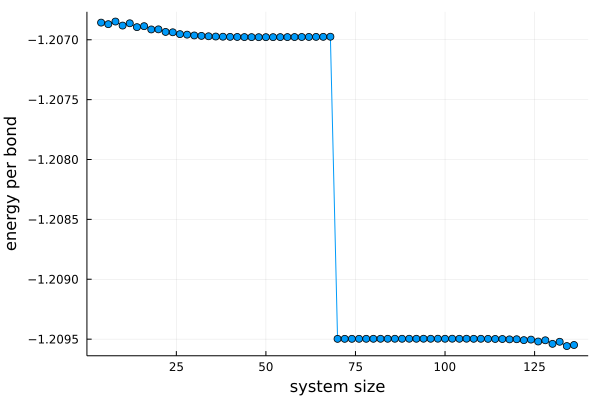

In [35]:
plot(System_Size,energy_per_bond,markershape = :circle,legend = false,xlabel = "system size",ylabel ="energy per bond")